In [16]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"

MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME


## Quant

## Transformers

In [17]:
METHOD = "quant/hf"
METHOD_EXPORTS = EXPORTS / METHOD


In [18]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/quant/hf


In [19]:
# hf quant model sizes
hf_quant_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir()]
hf_quant_models.append(MODEL_PATH)

AWQ_EXPORTS=EXPORTS / "quant/awq"
awq_models = [x for x in AWQ_EXPORTS.iterdir() if x.is_dir()]
hf_quant_models.extend(awq_models)

for model in hf_quant_models:

    # model_size := size of output.safetensors or <model>.p
    model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

gptq_3: 2.87 GiB
gptq_8: 6.67 GiB
gptq_2: 2.11 GiB
gptq_4: 3.63 GiB
Llama-2-7b-hf: 12.55 GiB
gemm: 3.62 GiB
gemv: 3.62 GiB


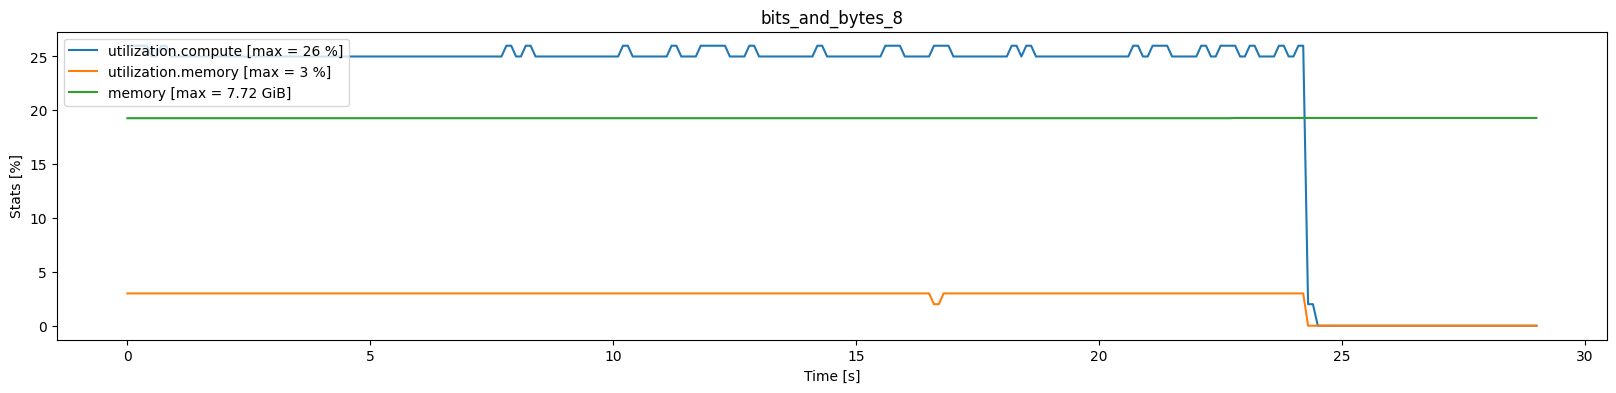

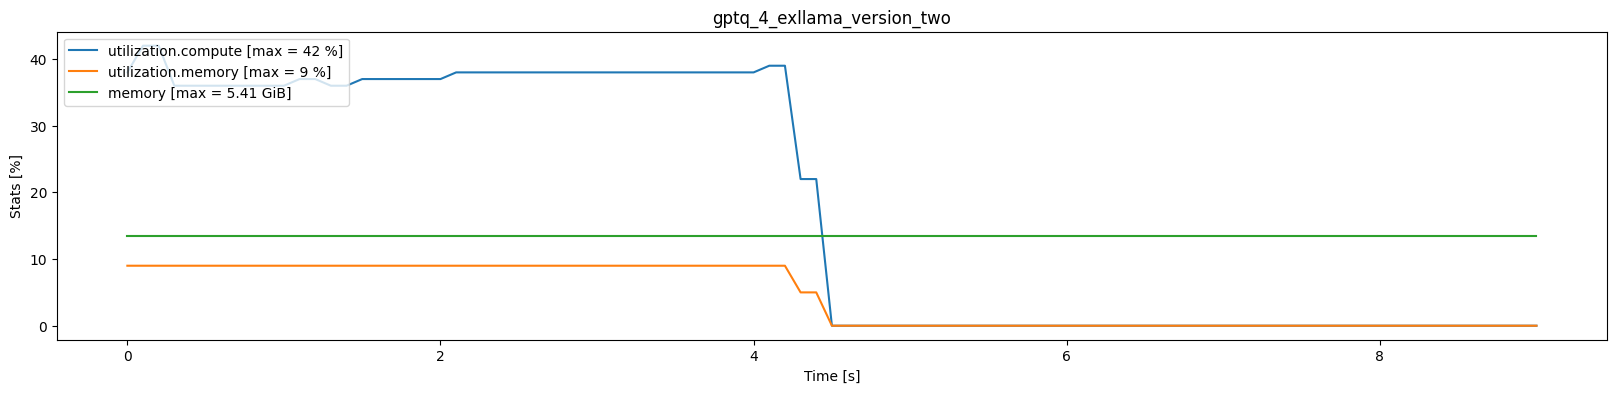

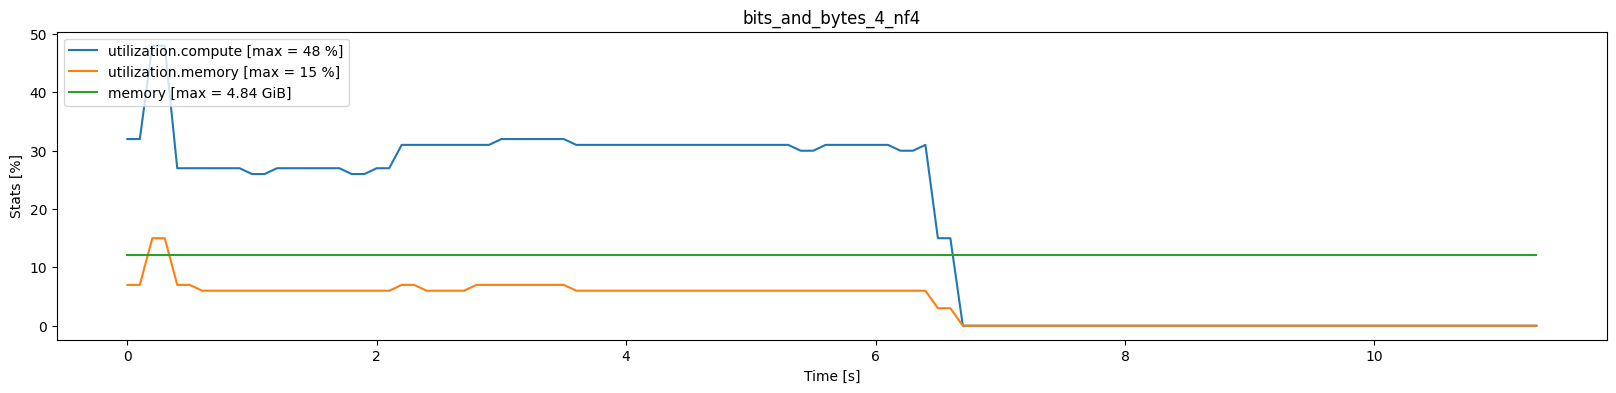

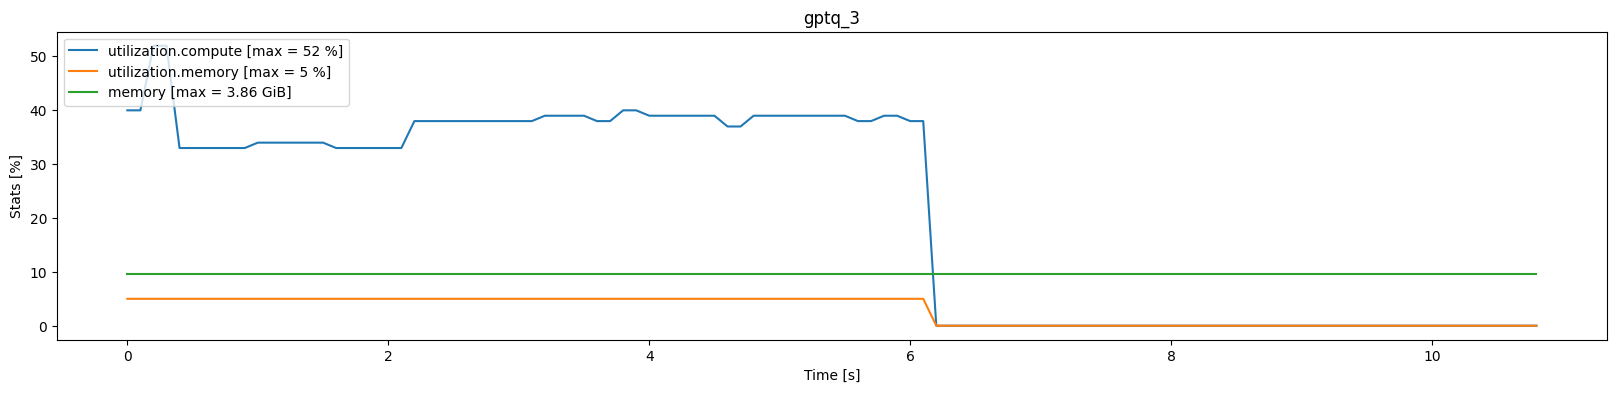

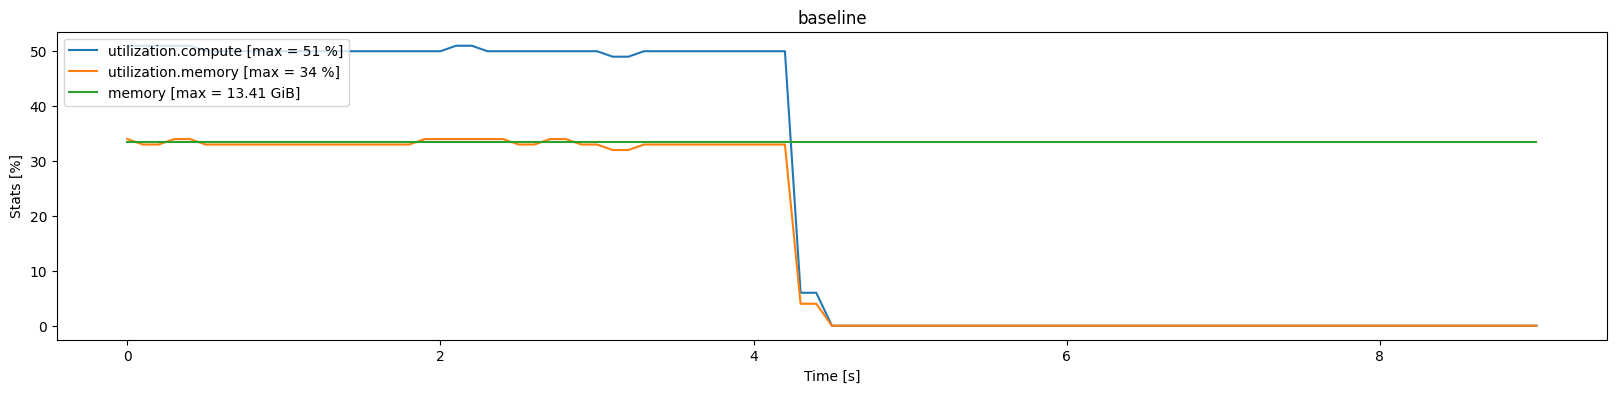

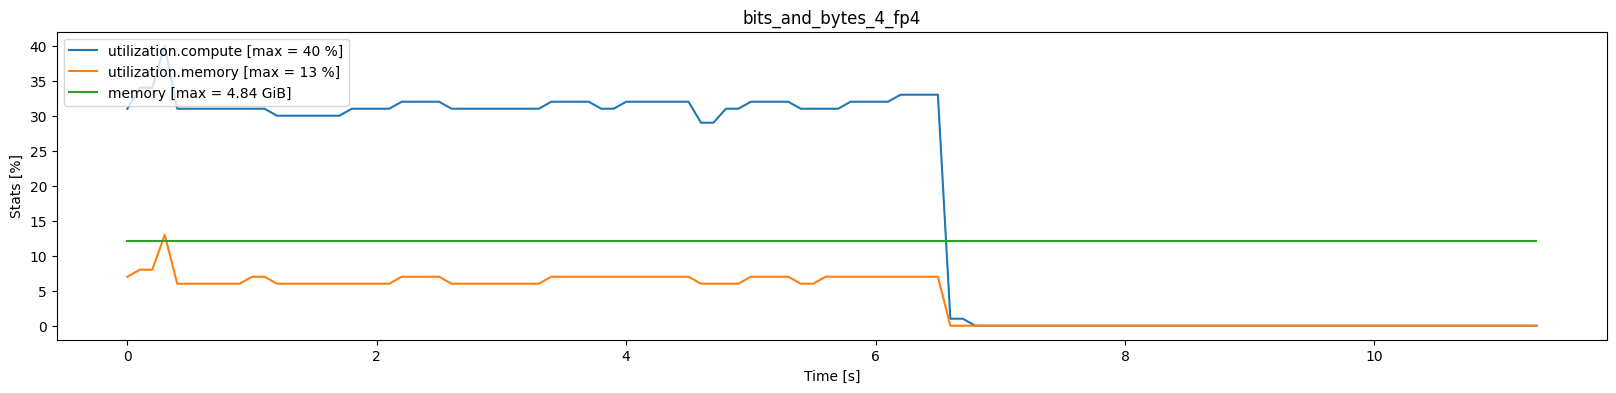

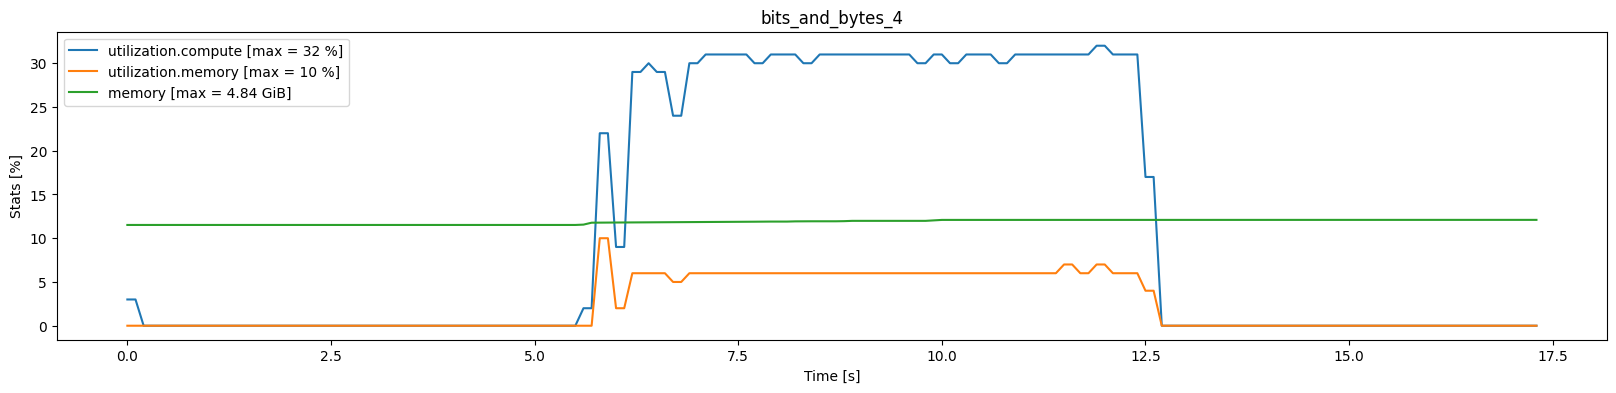

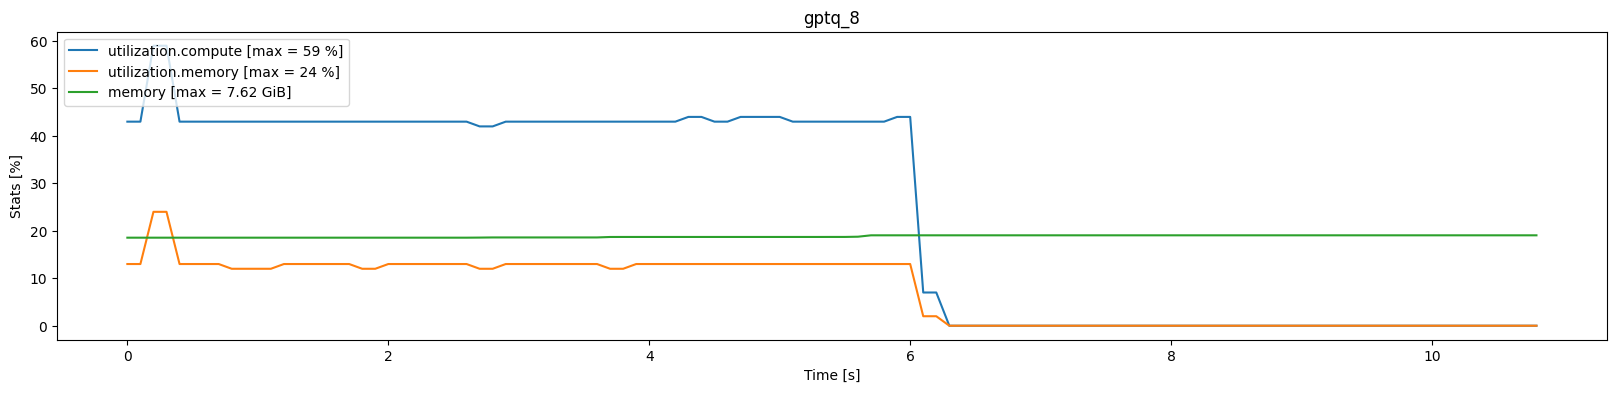

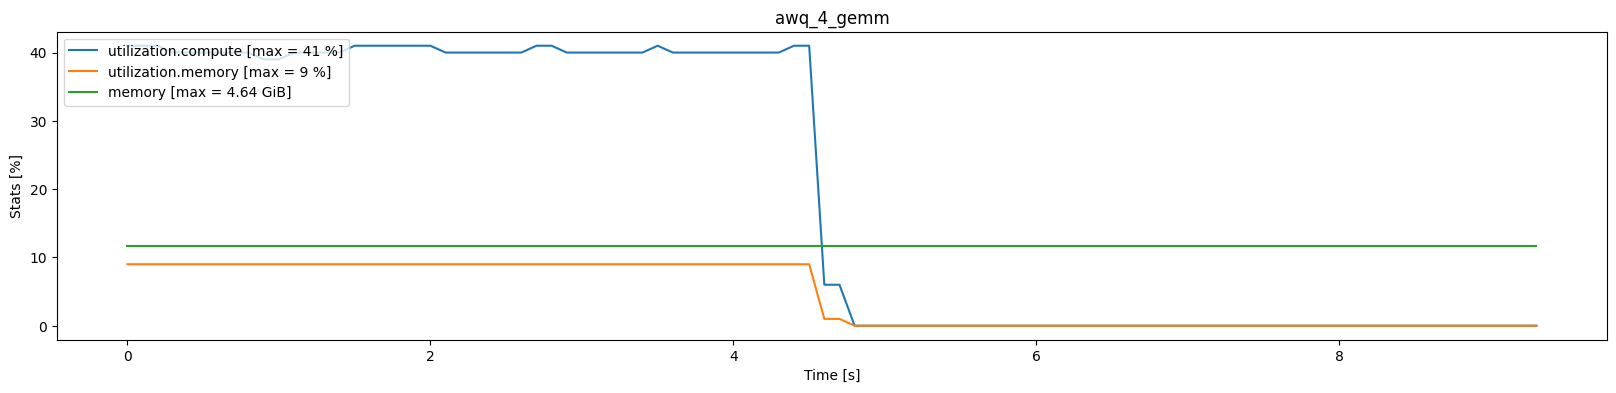

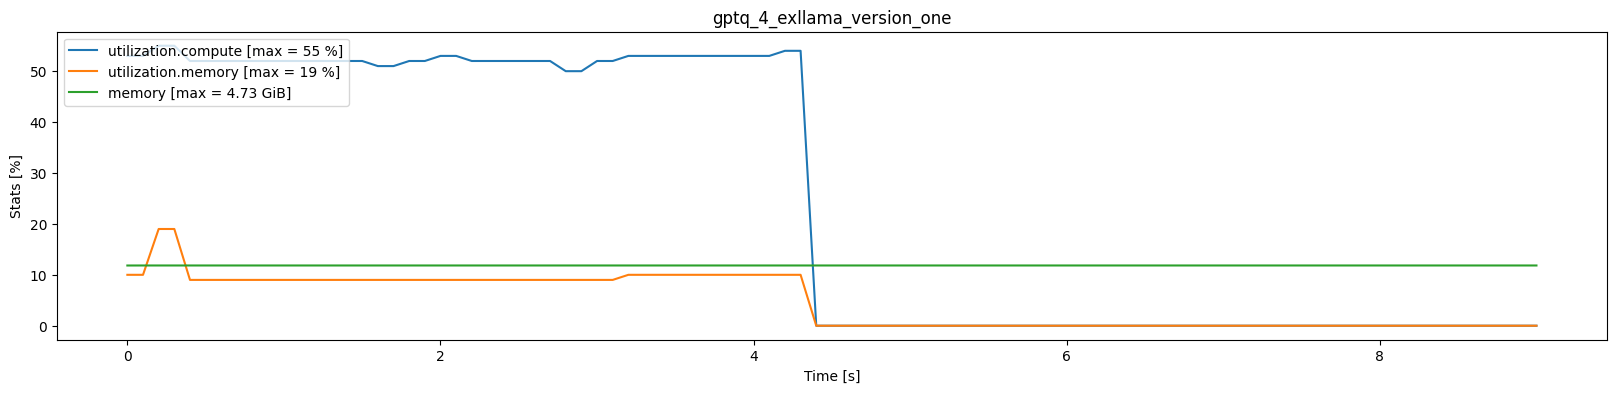

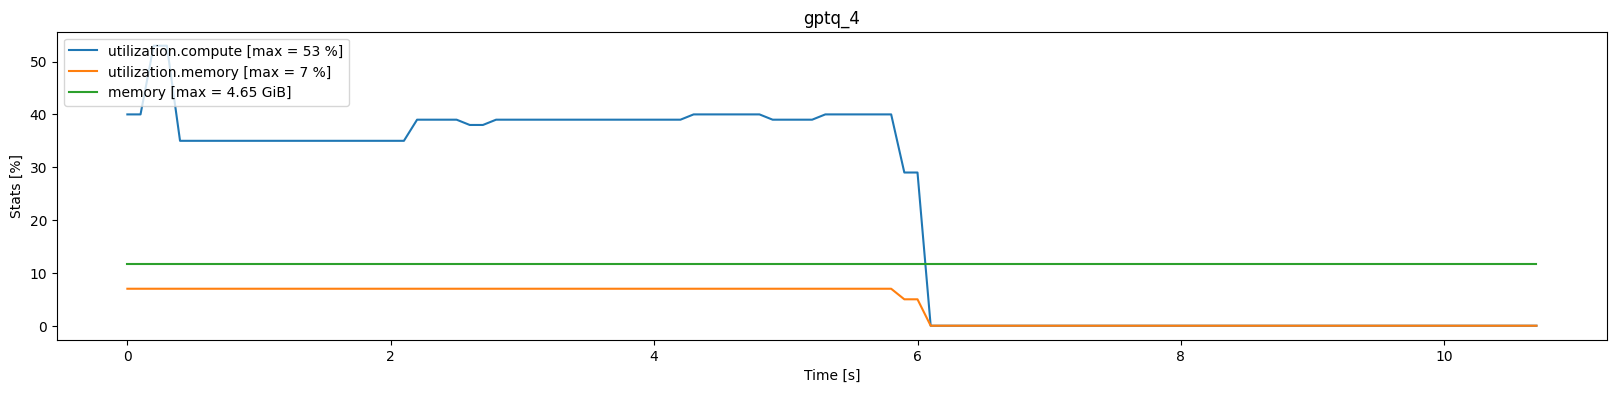

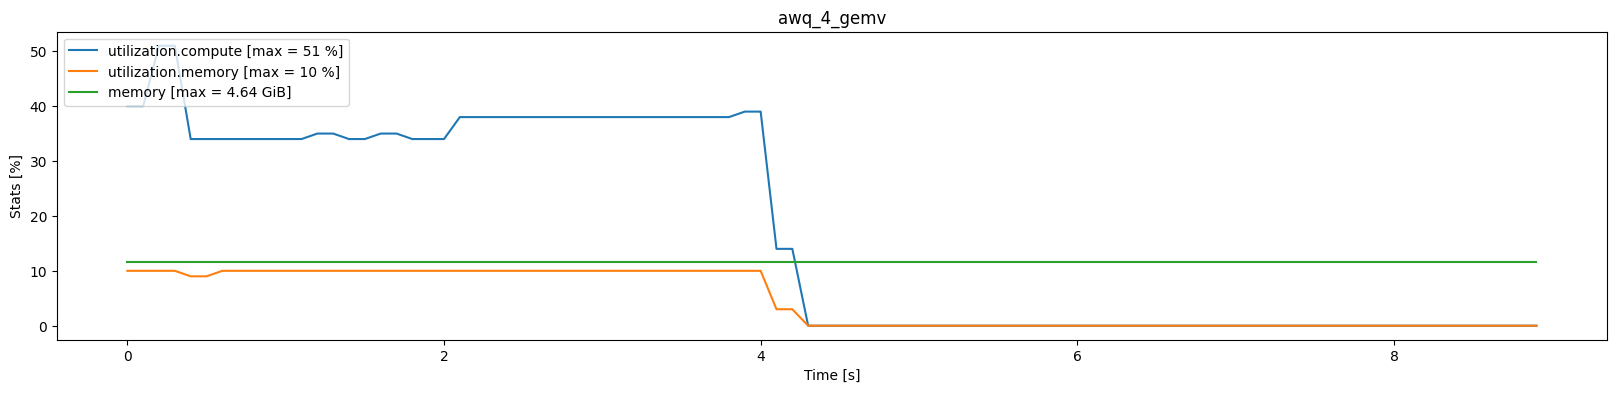

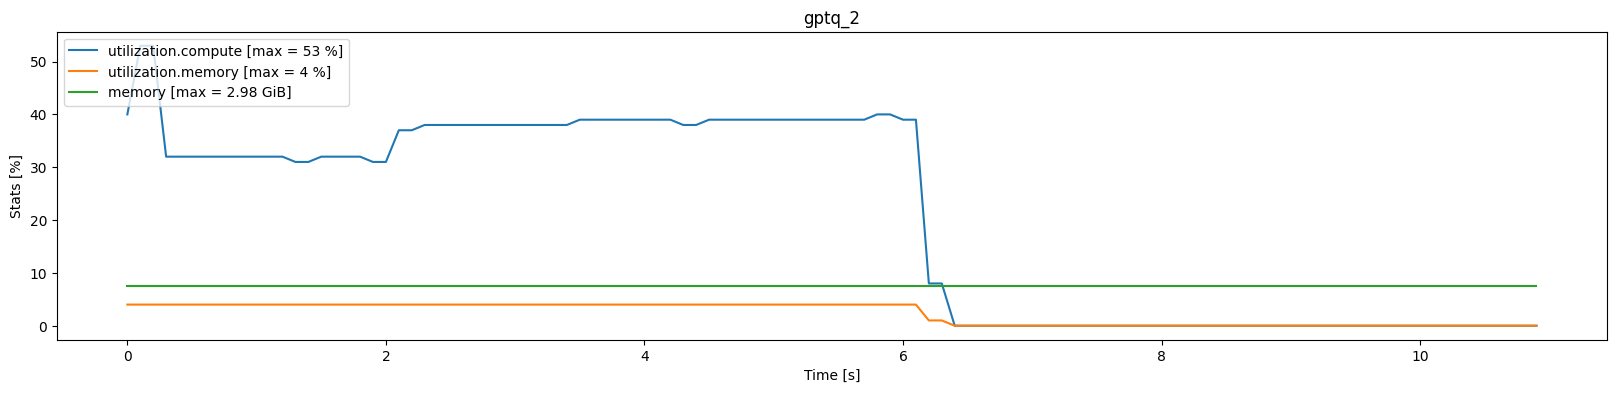

In [119]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)


    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")

In [120]:
# benchmark logs
import numpy as np

all_logs = list(METHOD_EXPORTS.glob("*.log"))
data = {}
for log in all_logs:
    if not "bench" in log.name or "ppl" in log.name:
        continue

    with open(log) as f:
        lines = f.readlines()
        header_line = filter(lambda x: "Quant:" in x, lines)
        header_line = list(header_line)[0]
        end_line = filter(lambda x: "Generated" in x, lines)
        end_line = list(end_line)[0]
        print(header_line.split(" ")[-2].strip())
        print(f"{lines[-4]}")
        tps = float(lines[-4].split(" ")[-2].strip()[1:])
        data[header_line.split(" ")[-2].strip()] = {"tps": tps}

bits_and_bytes_8
Generated 128 tokens in 24.415091514587402 seconds (5.242659030113535 tokens/s)

baseline
Generated 128 tokens in 4.143007755279541 seconds (30.895428529402658 tokens/s)

gptq_4_exllama_version_one
Generated 128 tokens in 4.205398321151733 seconds (30.43706926789865 tokens/s)

awq_4_gemv
Generated 128 tokens in 4.024226188659668 seconds (31.807357240680457 tokens/s)

gptq_4
Generated 128 tokens in 5.918351411819458 seconds (21.62764443901945 tokens/s)

gptq_2
Generated 128 tokens in 6.122849702835083 seconds (20.905298384301634 tokens/s)

gptq_4_exllama_version_two
Generated 128 tokens in 4.195513725280762 seconds (30.508778753055875 tokens/s)

bits_and_bytes_4_fp4
Generated 128 tokens in 6.454317808151245 seconds (19.831685362370454 tokens/s)

bits_and_bytes_4_nf4
Generated 128 tokens in 6.4958860874176025 seconds (19.704779036678826 tokens/s)

gptq_3
Generated 128 tokens in 6.027063846588135 seconds (21.23753841971653 tokens/s)

gptq_8
Generated 128 tokens in 5.99367

In [121]:
# ppl
all_logs = sorted(list(METHOD_EXPORTS.glob("*.log")))

for log in all_logs:
    if not "ppl" in log.name:
        continue

    with open(log) as f:
        lines = f.readlines()
        header_line = filter(lambda x: "Quant:" in x, lines)
        header_line = list(header_line)[0]
        end_line = filter(lambda x: "PPL Score" in x, lines)
        end_line = list(end_line)[0]
        print(header_line, end="")
        ppl_score = float(end_line.split("PPL Score: ")[-1])
        print(" ".join(end_line.split()[:2]), f"{ppl_score:.2f}\n")
        data[header_line.split()[-1]]["ppl"] = ppl_score

Quant: bits_and_bytes_4_fp4
PPL Score: 6.15

Quant: bits_and_bytes_4_nf4
PPL Score: 6.02

Quant: gptq_4_exllama_version_two
PPL Score: 6.08

Quant: bits_and_bytes_8
PPL Score: 5.89

Quant: awq_4_gemm
PPL Score: 6.02

Quant: awq_4_gemv
PPL Score: 6.02

Quant: gptq_2
PPL Score: nan

Quant: gptq_3
PPL Score: 7.36

Quant: gptq_4
PPL Score: 6.08

Quant: gptq_8
PPL Score: 5.86

Quant: gptq_4_exllama_version_one
PPL Score: 6.08

Quant: baseline
PPL Score: 5.85



In [122]:
import numpy as np
import pandas as pd
df = pd.DataFrame([(k.replace("_", " "), float(f"{v['tps']:.2f}"), float(f"{v['ppl']:.2f}")) for (k,v) in sorted(data.items())], columns=['method', 'tps', 'ppl'])
df["+ppl"] = df["ppl"] - min(df["ppl"])
df


,method,tps,ppl,+ppl
0,awq 4 gemm,28.51,6.02,0.17
1,awq 4 gemv,31.81,6.02,0.17
2,baseline,30.90,5.85,0.00
3,bits and bytes 4 fp4,19.83,6.15,0.30
4,bits and bytes 4 nf4,19.70,6.02,0.17
5,bits and bytes 8,5.24,5.89,0.04
6,gptq 2,20.91,NaN,NaN
7,gptq 3,21.24,7.36,1.51
8,gptq 4,21.63,6.08,0.23
9,gptq 4 exllama version one,30.44,6.08,0.23
